In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

from imblearn.over_sampling import SMOTE

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.probability import FreqDist

import re
import nltk
nltk.download(['stopwords',
               'punkt',
               'wordnet',
               'omw-1.4',
               'vader_lexicon'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jorom\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jorom\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jorom\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jorom\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jorom\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
# Define a list of English stop words using NLTK
stop_words = nltk.corpus.stopwords.words('english')

In [3]:
def preprocess_text(text):
    # Tokenize the text using a regular expression pattern
    tokenized_document = nltk.tokenize.RegexpTokenizer('[a-zA-Z0-9\']+').tokenize(text)
    
    # Remove stop words and convert to lowercase
    cleaned_tokens = [word.lower() for word in tokenized_document if word.lower() not in stop_words]
    
    # Apply stemming using the Porter Stemmer
    stemmed_text = [nltk.stem.PorterStemmer().stem(word) for word in cleaned_tokens]
    
    # Return the preprocessed text
    return stemmed_text

In [4]:
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv('TEXT MINING DATASET.csv')

In [5]:
# Capitalize the first letter of each column name
df.columns = df.columns.str.title()

In [6]:
# Display the contents, as well as the number of rows and columns in the DataFrame
df

,Author,Date,Location,Bank,Star,Text,Like
0,Kyle,31.08.2023,"Magnolia, TX",merrick_bank,5,Very easy to use to view statements and make o...,NaN
1,Julicia,23.08.2023,"Columbus, GA",merrick_bank,5,Merrick Bank has always been good to me for bu...,NaN
2,Karen,2.06.2023,"Marrero, LA",merrick_bank,4,Times are tough for everyone and I have worked...,3.0
3,Brent,29.03.2023,"Moultrie, GA",merrick_bank,5,I can not asked for a better Credit Card Compa...,3.0
4,Sharon,23.11.2022,"Burnham, IL",merrick_bank,5,Updated on 02/10/2023: I was happy to sign for...,3.0
...,...,...,...,...,...,...,...
19266,J.,30.01.2017,"Salem, OR",tcf_bank,1,Paid my 1st payment on time. They sent me a la...,11.0
19267,Destiny,28.01.2017,"Andover, MN",tcf_bank,1,I have banked with TCF for about 4 years now a...,12.0
19268,Sean,25.01.2017,"Bothell, WA",tcf_bank,1,Most inconvenient bank ever. As a business own...,10.0
19269,Edgar,12.01.2017,"Minneapolis, MI",tcf_bank,1,Well I've been with TCF Bank for 3 plus years ...,12.0


In [7]:
# Calculate and print the number of unique values in the column
columns_to_check = ['Author', 'Location', 'Bank']

for column in columns_to_check:
    unique_count = df[column].nunique()
    print(f"Number of {column.capitalize()}: {unique_count}")

Number of Author: 5700
Number of Location: 6286
Number of Bank: 47


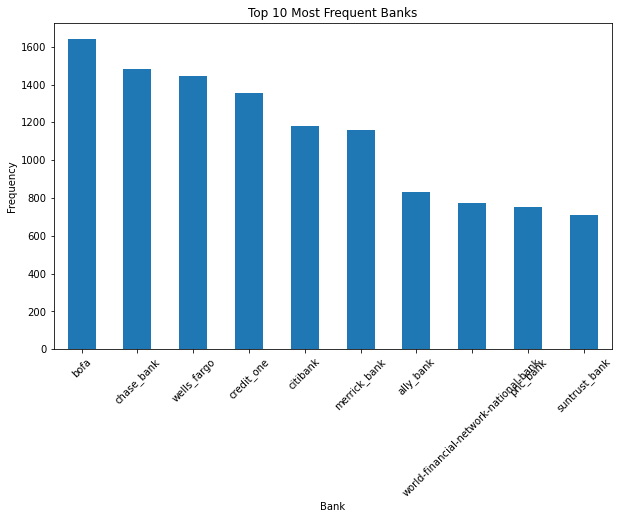

In [8]:
# Plotting the frequency count
bank_frequency = df['Bank'].value_counts().nlargest(10)

plt.figure(figsize=(10, 6))
bank_frequency.plot(kind='bar')
plt.title('Top 10 Most Frequent Banks')
plt.xlabel('Bank')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [9]:
# Display the number of missing values per column
df.isnull().sum()

Author         1
Date           0
Location       0
Bank           0
Star           0
Text          90
Like        1502
dtype: int64

In [10]:
# Display descriptive statistics for all columns in the DataFrame
df.describe(include='all')

,Author,Date,Location,Bank,Star,Text,Like
count,19270,19271,19271,19271,19271.000000,19181,17769.000000
unique,5700,2418,6286,47,NaN,19180,NaN
top,John,16.02.2018,"Chicago, IL",bofa,NaN,I transferred $10K from Chase to PNC Bank last...,NaN
freq,244,73,182,1643,NaN,2,NaN
mean,NaN,NaN,NaN,NaN,1.432567,NaN,11.109291
std,NaN,NaN,NaN,NaN,1.151793,NaN,8.091683
min,NaN,NaN,NaN,NaN,1.000000,NaN,2.000000
25%,NaN,NaN,NaN,NaN,1.000000,NaN,6.000000
50%,NaN,NaN,NaN,NaN,1.000000,NaN,9.000000
75%,NaN,NaN,NaN,NaN,1.000000,NaN,14.000000


In [11]:
# Display the DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19271 entries, 0 to 19270
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Author    19270 non-null  object 
 1   Date      19271 non-null  object 
 2   Location  19271 non-null  object 
 3   Bank      19271 non-null  object 
 4   Star      19271 non-null  int64  
 5   Text      19181 non-null  object 
 6   Like      17769 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 1.0+ MB


In [12]:
# Drop rows with missing values in 'Text' and 'Author' columns
df.dropna(subset=['Text', 'Author'], inplace=True)

# Reset the index after dropping rows
df.reset_index(drop=True, inplace=True)

In [13]:
# Fill missing values in the 'Like' column with 0
df['Like'].fillna(0, inplace=True)

In [14]:
# Display the contents, as well as the number of rows and columns in the DataFrame after data cleaning.
df

,Author,Date,Location,Bank,Star,Text,Like
0,Kyle,31.08.2023,"Magnolia, TX",merrick_bank,5,Very easy to use to view statements and make o...,0.0
1,Julicia,23.08.2023,"Columbus, GA",merrick_bank,5,Merrick Bank has always been good to me for bu...,0.0
2,Karen,2.06.2023,"Marrero, LA",merrick_bank,4,Times are tough for everyone and I have worked...,3.0
3,Brent,29.03.2023,"Moultrie, GA",merrick_bank,5,I can not asked for a better Credit Card Compa...,3.0
4,Sharon,23.11.2022,"Burnham, IL",merrick_bank,5,Updated on 02/10/2023: I was happy to sign for...,3.0
...,...,...,...,...,...,...,...
19175,J.,30.01.2017,"Salem, OR",tcf_bank,1,Paid my 1st payment on time. They sent me a la...,11.0
19176,Destiny,28.01.2017,"Andover, MN",tcf_bank,1,I have banked with TCF for about 4 years now a...,12.0
19177,Sean,25.01.2017,"Bothell, WA",tcf_bank,1,Most inconvenient bank ever. As a business own...,10.0
19178,Edgar,12.01.2017,"Minneapolis, MI",tcf_bank,1,Well I've been with TCF Bank for 3 plus years ...,12.0


In [15]:
# Display the DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19180 entries, 0 to 19179
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Author    19180 non-null  object 
 1   Date      19180 non-null  object 
 2   Location  19180 non-null  object 
 3   Bank      19180 non-null  object 
 4   Star      19180 non-null  int64  
 5   Text      19180 non-null  object 
 6   Like      19180 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 1.0+ MB


In [16]:
# Display descriptive statistics for all columns in the DataFrame
df.describe(include='all')

,Author,Date,Location,Bank,Star,Text,Like
count,19180,19180,19180,19180,19180.000000,19180,19180.000000
unique,5674,2417,6267,47,NaN,19179,NaN
top,John,16.02.2018,"Chicago, IL",bofa,NaN,I transferred $10K from Chase to PNC Bank last...,NaN
freq,244,73,182,1637,NaN,2,NaN
mean,NaN,NaN,NaN,NaN,1.433212,NaN,10.247706
std,NaN,NaN,NaN,NaN,1.152790,NaN,8.327648
min,NaN,NaN,NaN,NaN,1.000000,NaN,0.000000
25%,NaN,NaN,NaN,NaN,1.000000,NaN,5.000000
50%,NaN,NaN,NaN,NaN,1.000000,NaN,9.000000
75%,NaN,NaN,NaN,NaN,1.000000,NaN,13.000000


In [17]:
# Display the number of missing values per column
df.isnull().sum()

Author      0
Date        0
Location    0
Bank        0
Star        0
Text        0
Like        0
dtype: int64

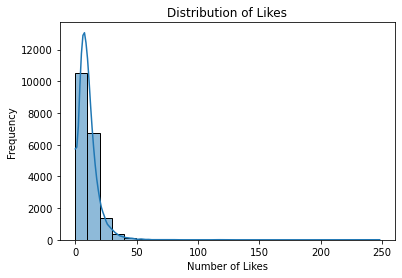

In [18]:
# Create a distribution plot for the 'Like' column with limited bins
sns.histplot(df['Like'], kde = True, bins = 25)

# Set plot labels and title
plt.xlabel('Number of Likes')
plt.ylabel('Frequency')
plt.title('Distribution of Likes')

# Show the plot
plt.show()

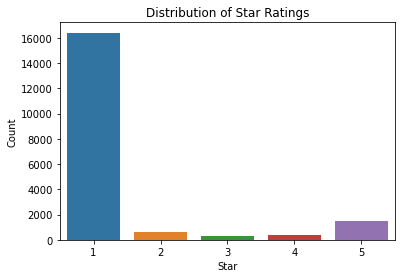

In [19]:
# Create a bar countplot for the 'Star' column
sns.countplot(x='Star', data=df)
plt.xlabel('Star')
plt.ylabel('Count')
plt.title('Distribution of Star Ratings')
plt.show()

In [20]:
# Create a copy of the DataFrame df and assign it to df_sentiment
df_sentiment = df.copy()

In [21]:
# Apply the preprocess_text function to the 'Text' column in the DataFrame
df['Text'] = df['Text'].apply(preprocess_text)

# Display the first 5 rows of the DataFrame after text preprocessing
df.head(5)

,Author,Date,Location,Bank,Star,Text,Like
0,Kyle,31.08.2023,"Magnolia, TX",merrick_bank,5,"[easi, use, view, statement, make, onlin, paym...",0.0
1,Julicia,23.08.2023,"Columbus, GA",merrick_bank,5,"[merrick, bank, alway, good, busi, reli, merri...",0.0
2,Karen,2.06.2023,"Marrero, LA",merrick_bank,4,"[time, tough, everyon, work, hard, get, credit...",3.0
3,Brent,29.03.2023,"Moultrie, GA",merrick_bank,5,"[ask, better, credit, card, compani, merrick, ...",3.0
4,Sharon,23.11.2022,"Burnham, IL",merrick_bank,5,"[updat, 02, 10, 2023, happi, sign, new, credit...",3.0


In [22]:
# Create a CountVectorizer and transform the 'Text' column into a bag-of-words representation
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(df['Text'].map(' '.join))

# Convert the sparse matrix to a DataFrame with feature names as columns
x = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())

# Display the first 5 rows of the DataFrame representing the bag-of-words
x.head(5)

,00,000,0000,000000,0000000,00000000,00001,0001,0002,000cdn,...,zill,zillion,zillow,zip,zombi,zone,zonk,zoo,zr,zulu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Assign the 'Star' column as the target variable (y)
y = df['Star']

# Split the data into training and testing sets using train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=0)

<AxesSubplot:xlabel='Star', ylabel='count'>

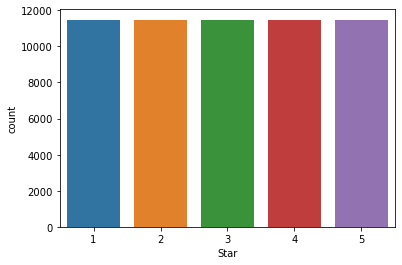

In [24]:
# Apply SMOTE (Synthetic Minority Over-sampling Technique) to balance the classes in the training set
resampler = SMOTE(random_state=0)
x_train_smote, y_train_smote = resampler.fit_resample(x_train, y_train)

# Create a countplot to visualize the balanced distribution of classes after SMOTE
sns.countplot(x=y_train_smote)

In [25]:
# Create a Multinomial Naive Bayes model and fit it to the SMOTE-resampled training data
model = MultinomialNB()
model.fit(x_train_smote, y_train_smote)

MultinomialNB()

In [26]:
# Generate predictions on the test data using the trained Multinomial Naive Bayes model
y_pred = model.predict(x_test)

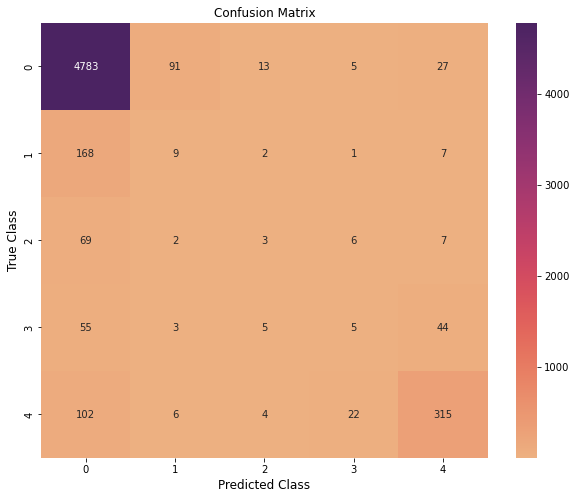

In [27]:
# Create a confusion matrix and visualize it using a heatmap
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm, cmap='flare', annot=True, fmt='d')

plt.xlabel("Predicted Class", fontsize=12)
plt.ylabel("True Class", fontsize=12)
plt.title("Confusion Matrix", fontsize=12)
plt.show()

In [28]:
# Calculate and print the accuracy of the model on the test data
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted') 
f1 = f1_score(y_test, y_pred, average='weighted') 

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

Accuracy: 88.89%
Precision: 85.81%
Recall: 88.89%
F1 Score: 87.20%


In [29]:
# Print the classification report for the model's performance on the test data
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.97      0.95      4919
           2       0.08      0.05      0.06       187
           3       0.11      0.03      0.05        87
           4       0.13      0.04      0.07       112
           5       0.79      0.70      0.74       449

    accuracy                           0.89      5754
   macro avg       0.41      0.36      0.37      5754
weighted avg       0.86      0.89      0.87      5754



In [30]:
# Create an instance of the SentimentIntensityAnalyzer for sentiment analysis
sentiment = SentimentIntensityAnalyzer()

In [31]:
# Analyze sentiment and create new columns for compound, negative, neutral, and positive scores
df_sentiment['compound'] = [sentiment.polarity_scores(review)['compound'] for review in df_sentiment['Text']]
df_sentiment['neg'] = [sentiment.polarity_scores(review)['neg'] for review in df_sentiment['Text']]
df_sentiment['neu'] = [sentiment.polarity_scores(review)['neu'] for review in df_sentiment['Text']]
df_sentiment['pos'] = [sentiment.polarity_scores(review)['pos'] for review in df_sentiment['Text']]

In [32]:
# Display the first 5 rows of the DataFrame with sentiment analysis scores
df_sentiment.head(5)

,Author,Date,Location,Bank,Star,Text,Like,compound,neg,neu,pos
0,Kyle,31.08.2023,"Magnolia, TX",merrick_bank,5,Very easy to use to view statements and make o...,0.0,0.8976,0.110,0.610,0.280
1,Julicia,23.08.2023,"Columbus, GA",merrick_bank,5,Merrick Bank has always been good to me for bu...,0.0,0.9774,0.000,0.622,0.378
2,Karen,2.06.2023,"Marrero, LA",merrick_bank,4,Times are tough for everyone and I have worked...,3.0,0.9552,0.044,0.760,0.195
3,Brent,29.03.2023,"Moultrie, GA",merrick_bank,5,I can not asked for a better Credit Card Compa...,3.0,0.9849,0.042,0.655,0.304
4,Sharon,23.11.2022,"Burnham, IL",merrick_bank,5,Updated on 02/10/2023: I was happy to sign for...,3.0,0.9331,0.028,0.834,0.138


In [33]:
# Display descriptive statistics for sentiment analysis scores in the DataFrame
df_sentiment[['compound', 'neg', 'neu', 'pos']].describe()

,compound,neg,neu,pos
count,19180.000000,19180.000000,19180.000000,19180.000000
mean,-0.096966,0.086650,0.830057,0.083294
std,0.684607,0.061251,0.084933,0.075331
min,-0.994900,0.000000,0.000000,0.000000
25%,-0.765000,0.042000,0.781000,0.033000
50%,-0.253750,0.078000,0.840000,0.065000
75%,0.612400,0.122000,0.891000,0.111000
max,0.995700,0.523000,1.000000,1.000000


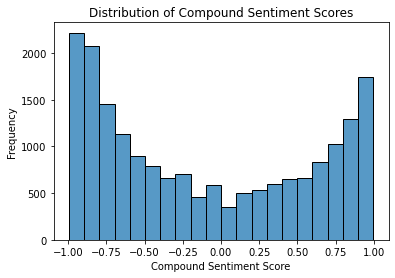

In [34]:
# Create a histogram plot for the 'compound' sentiment scores
sns.histplot(df_sentiment['compound'])
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Compound Sentiment Scores')
plt.show()

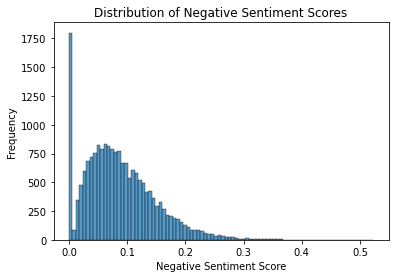

In [35]:
# Create a histogram plot for the 'neg' sentiment scores
sns.histplot(df_sentiment['neg'])
plt.xlabel('Negative Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Negative Sentiment Scores')
plt.show()

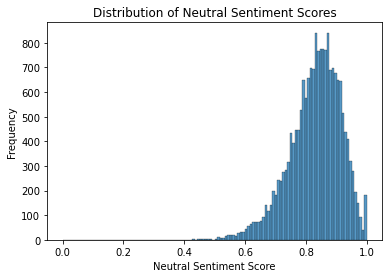

In [36]:
# Create a histogram plot for the 'neu' sentiment scores
sns.histplot(df_sentiment['neu'])
plt.xlabel('Neutral Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Neutral Sentiment Scores')
plt.show()

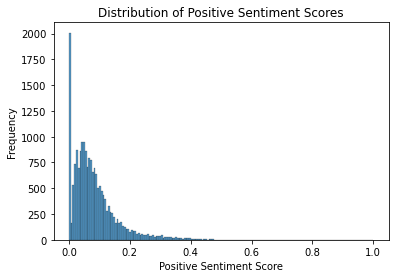

In [37]:
# Create a histogram plot for the 'pos' sentiment scores
sns.histplot(df_sentiment['pos'])
plt.xlabel('Positive Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Positive Sentiment Scores')
plt.show()

In [38]:
# Count the number of negative or neutral sentiment scores grouped by the 'Bank' column
(df_sentiment['compound'] <= 0).groupby(df_sentiment['Bank']).sum()

Bank
ally_bank                                 536
armed_forces_bank                          32
arrowhead_credit_union_ca                   6
arvest-bank                                31
associated                                 29
bank_of_the_west                          142
bbt_bank                                  265
bmo-harris-bank                             0
bofa                                     1003
bofa_gift_card                              2
chase_bank                                944
cit-bank                                    2
citibank                                  712
citizens_bank_ri                          274
comerica_bank                              66
compass_bank                              126
credit_one                                705
crescent_bank_la                           34
discover-bank                              42
fifth_third                               360
first-tech-federal-credit-union             0
first_citizens_bank_nc       

In [39]:
# Calculate the percentage of negative reviews and create a DataFrame
percent_negative = pd.DataFrame((df_sentiment['compound'] <= 0).groupby(df_sentiment['Bank']).sum()
                                / df_sentiment['Bank'].groupby(df_sentiment['Bank']).count() * 100,
                                columns=['% Negative Reviews']).sort_values(by='% Negative Reviews')

# Display the DataFrame with the percentage of negative reviews
percent_negative

,% Negative Reviews
Bank,
liberty-federal-credit-union,0.000000
first-tech-federal-credit-union,0.000000
bmo-harris-bank,0.000000
merrick_bank,18.377912
first_national_bank_omaha,37.272727
world-financial-network-national-bank,47.204161
navy_federal,47.651007
bofa_gift_card,50.000000
wells_fargo,51.145038


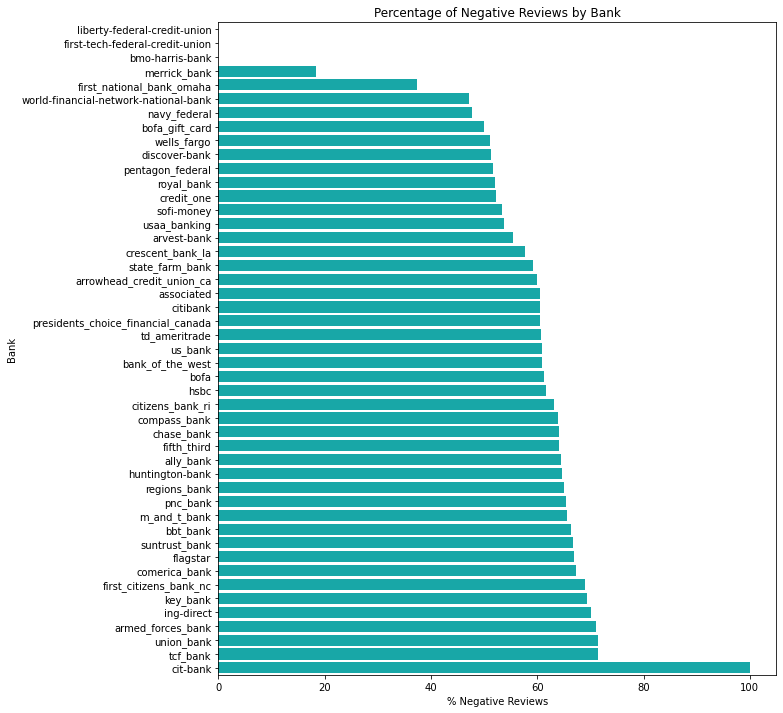

In [40]:
# Create a plot to visualize the negative reviews per bank
plt.figure(figsize=(10, 12))
sns.barplot(data=percent_negative, x='% Negative Reviews', y=percent_negative.index, color='c', orient='h')

# Add labels and title
plt.xlabel('% Negative Reviews')
plt.ylabel('Bank')
plt.title('Percentage of Negative Reviews by Bank')

# Show the plot
plt.show()

In [41]:
# Apply text preprocessing to the 'Text' column and create a new column 'processed_text'
df_sentiment['processed_text'] = df_sentiment['Text'].apply(preprocess_text)

# Create subsets for positive and negative reviews for 1st most frequent bank 'bofa'
reviews_positive_subset = df_sentiment.loc[(df_sentiment['Bank'] == 'bofa')
                                           & (df_sentiment['compound'] > 0), :]

reviews_negative_subset = df_sentiment.loc[(df_sentiment['Bank'] == 'bofa')
                                           & (df_sentiment['compound'] <= 0), :]

In [42]:
# Display the first 5 rows of the subset containing positive reviews for 'bofa'
reviews_positive_subset.head(5)

,Author,Date,Location,Bank,Star,Text,Like,compound,neg,neu,pos,processed_text
6144,Allen,27.08.2023,"Roswell, GA",bofa,1,THE. WORST. BANK. EVER. They force their custo...,4.0,0.7345,0.135,0.664,0.202,"[worst, bank, ever, forc, custom, use, debit, ..."
6148,Orlando,10.08.2023,"North Port, FL",bofa,1,"I took my Son and his wife ""who came to the US...",0.0,0.8910,0.020,0.877,0.103,"[took, son, wife, came, us, cuba, two, month, ..."
6151,Jessica,20.07.2023,"Los Angeles, CA",bofa,1,Horrible experience 7/20/23-10:30am at 91403. ...,3.0,0.3291,0.116,0.789,0.095,"[horribl, experi, 7, 20, 23, 10, 30am, 91403, ..."
6154,Anthony,8.07.2023,"Mahwah, NJ",bofa,5,I was helping my 87 yrs old injured home bound...,0.0,0.8188,0.113,0.639,0.248,"[help, 87, yr, old, injur, home, bound, mother..."
6167,Robbie,8.05.2023,"Fort Myers, FL",bofa,1,I tried withdrawing my 401k by phone and they ...,5.0,0.1657,0.046,0.904,0.051,"[tri, withdraw, 401k, phone, made, imposs, sai..."


In [43]:
# Display the first 5 rows of the subset containing negative reviews for 'bofa'
reviews_negative_subset.head(5)

,Author,Date,Location,Bank,Star,Text,Like,compound,neg,neu,pos,processed_text
6139,Rafael,12.09.2023,"Oceanside, CA",bofa,2,How do you manage automatic payments on BofA w...,0.0,-0.3939,0.139,0.753,0.108,"[manag, automat, payment, bofa, websit, paymen..."
6140,Ronit,1.09.2023,"North Miami Beach, FL",bofa,1,Will never use this bank anymore. I was on the...,0.0,-0.3987,0.102,0.807,0.091,"[never, use, bank, anymor, phone, 6, 19, 2023,..."
6141,JayJohn,1.09.2023,"Washington, DC",bofa,1,Bank of America is not equipped to deposit che...,0.0,-0.9479,0.121,0.872,0.007,"[bank, america, equip, deposit, check, via, mo..."
6142,Douglas,30.08.2023,"Deltona, FL",bofa,1,Apparently Fraud was detected on my checking a...,3.0,-0.9377,0.128,0.858,0.014,"[appar, fraud, detect, check, account, bank, a..."
6143,Douglas,29.08.2023,"Deltona, FL",bofa,1,The people at the call center are are inexperi...,0.0,-0.4215,0.142,0.756,0.102,"[peopl, call, center, inexperienc, lack, prope..."


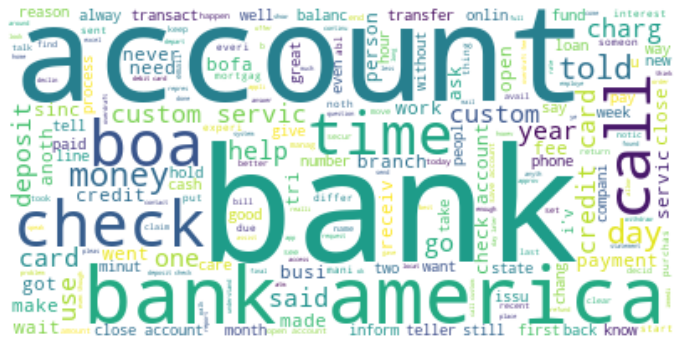

In [44]:
# Extract words from the processed text of positive reviews for 'bofa'
pos_tokens = [word for review in reviews_positive_subset['processed_text'] for word in review]

# Create a WordCloud from the positive tokens
wordcloud = WordCloud(background_color='white').generate_from_text(' '.join(pos_tokens))

# Display the WordCloud for positive reviews
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

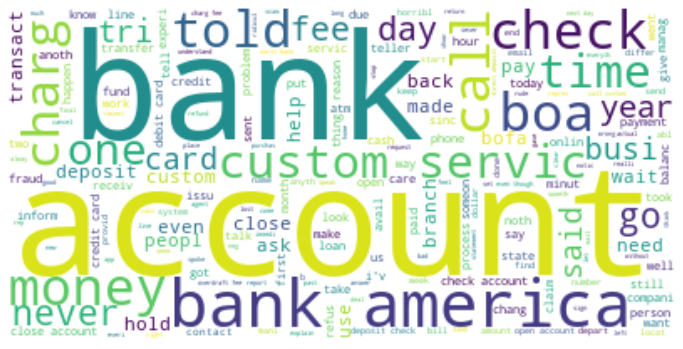

In [45]:
# Extract words from the processed text of negative reviews for 'bofa'
neg_tokens = [word for review in reviews_negative_subset['processed_text'] for word in review]

# Create a WordCloud from the negative tokens
wordcloud = WordCloud(background_color='white').generate_from_text(' '.join(neg_tokens))

# Display the WordCloud for negative reviews
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

   bank account   check america  custom    card  credit    call     day  servic 
   1009     787     473     414     376     351     330     295     273     265 


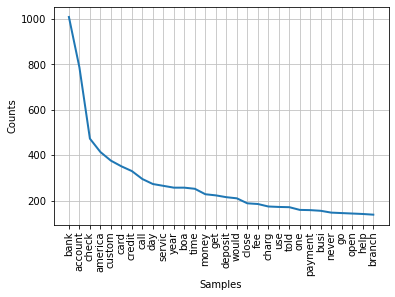

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [46]:
# Create a Frequency Distribution for positive tokens and display the top 10 most common words
pos_freqdist = FreqDist(pos_tokens)
pos_freqdist.tabulate(10)

# Visualize the Frequency Distribution for positive tokens using a bar plot
pos_freqdist.plot(30)

   bank account   check america  custom   money    call    time   charg  servic 
   1609    1364     657     609     587     544     511     435     430     423 


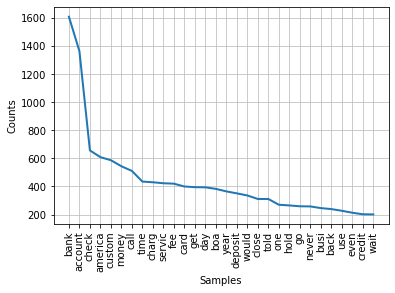

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [47]:
# Create a Frequency Distribution for negative tokens and display the top 10 most common words
neg_freqdist = FreqDist(neg_tokens)
neg_freqdist.tabulate(10)

# Visualize the Frequency Distribution for negative tokens using a bar plot
neg_freqdist.plot(30)

In [48]:
# Create subsets for positive and negative reviews for 2nd most frequent bank 'chase_bank'
reviews_positive_subset = df_sentiment.loc[(df_sentiment['Bank'] == 'chase_bank')
                                           & (df_sentiment['compound'] > 0), :]

reviews_negative_subset = df_sentiment.loc[(df_sentiment['Bank'] == 'chase_bank')
                                           & (df_sentiment['compound'] <= 0), :]

In [49]:
# Display the first 5 rows of the subset containing positive reviews for 'chase_bank'
reviews_positive_subset.head(5)

,Author,Date,Location,Bank,Star,Text,Like,compound,neg,neu,pos,processed_text
13711,Erika,14.09.2023,"Asheville, NC",chase_bank,5,I just wanted to make a quick note that Chase ...,0.0,0.2178,0.075,0.843,0.082,"[want, make, quick, note, chase, bank, easiest..."
13712,Albana,4.08.2023,"Pelham, NY",chase_bank,5,I want to say a big thank you to Mr. Christoph...,0.0,0.9628,0.000,0.702,0.298,"[want, say, big, thank, mr, christoph, excel, ..."
13713,asdf,18.04.2023,"Santa Barbara, CA",chase_bank,5,Honest and dependable service. A solid choice ...,4.0,0.9451,0.045,0.556,0.399,"[honest, depend, servic, solid, choic, uncerta..."
13714,Victoria,16.03.2023,"Rochester, MN",chase_bank,5,Chase bank saved my money from many trouble se...,4.0,0.9523,0.052,0.544,0.404,"[chase, bank, save, money, mani, troubl, selle..."
13715,Felicia,21.10.2022,"Memphis, TN",chase_bank,4,I’m amazed at the interest rate at which Chase...,4.0,0.9151,0.101,0.577,0.322,"[amaz, interest, rate, chase, bank, provid, ca..."


In [50]:
# Display the first 5 rows of the subset containing negative reviews for 'chase_bank'
reviews_negative_subset.head(5)

,Author,Date,Location,Bank,Star,Text,Like,compound,neg,neu,pos,processed_text
13717,robert,17.09.2023,"Holiday, FL",chase_bank,1,I have had to replace my debit card for fraudu...,0.0,-0.8536,0.220,0.730,0.051,"[replac, debit, card, fraudul, charg, sever, t..."
13719,Anne,13.09.2023,"Portland, OR",chase_bank,1,"On Sept 8, 2023, when I went to pay a bill onl...",0.0,-0.8991,0.146,0.778,0.076,"[sept, 8, 2023, went, pay, bill, onlin, confro..."
13721,Rahul,9.09.2023,"Burlingame, CA",chase_bank,1,Bankers in Burlingame branch doesn't deserve t...,0.0,-0.7623,0.138,0.810,0.051,"[banker, burlingam, branch, deserv, job, take,..."
13722,Stefan,6.09.2023,"Grayslake, IL",chase_bank,1,Recently I closed all my bank accounts with jp...,5.0,-0.8490,0.182,0.818,0.000,"[recent, close, bank, account, jpmchase, bank,..."
13723,Jen,2.09.2023,"Waverley, MA",chase_bank,1,For no reason they suddenly closed my account ...,6.0,-0.2168,0.115,0.807,0.078,"[reason, suddenli, close, account, give, money..."


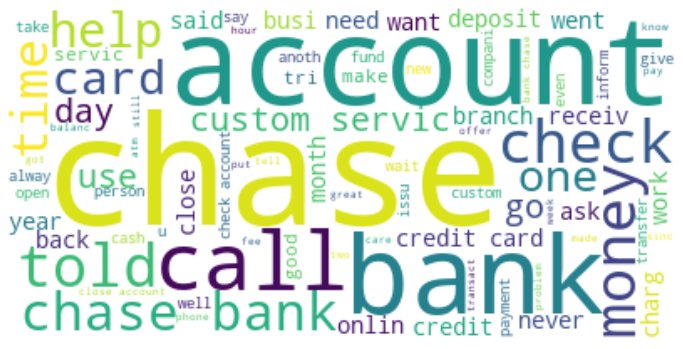

In [51]:
# Extract words from the processed text of positive reviews for 'chase_bank'
pos_tokens = [word for review in reviews_positive_subset['processed_text'] for word in review]

# Create a WordCloud from the positive tokens
wordcloud = WordCloud(background_color='white').generate_from_text(' '.join(pos_tokens))

# Display the WordCloud for positive reviews
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

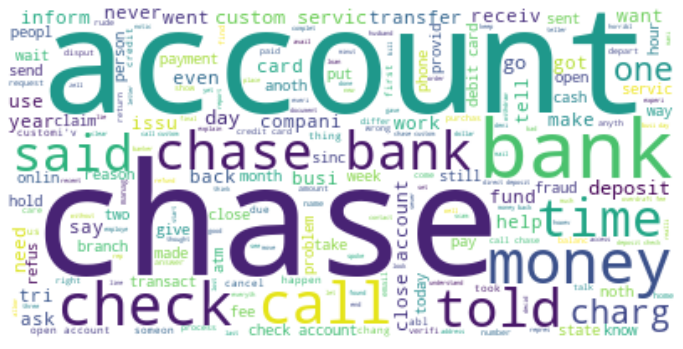

In [52]:
# Extract words from the processed text of negative reviews for 'chase_bank'
neg_tokens = [word for review in reviews_negative_subset['processed_text'] for word in review]

# Create a WordCloud from the negative tokens
wordcloud = WordCloud(background_color='white').generate_from_text(' '.join(neg_tokens))

# Display the WordCloud for negative reviews
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

  chase account    bank   check    card  custom  credit    call  servic   money 
    840     782     645     361     306     284     252     249     232     210 


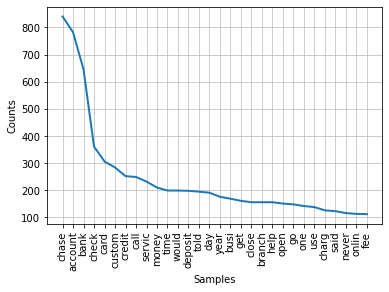

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [53]:
# Create a Frequency Distribution for positive tokens and display the top 10 most common words
pos_freqdist = FreqDist(pos_tokens)
pos_freqdist.tabulate(10)

# Visualize the Frequency Distribution for positive tokens using a bar plot
pos_freqdist.plot(30)

  chase account    bank   check   money    call  custom    card    time     day 
   1518    1441    1140     694     649     617     483     430     410     395 


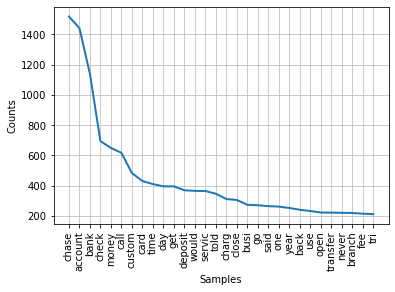

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [54]:
# Create a Frequency Distribution for negative tokens and display the top 10 most common words
neg_freqdist = FreqDist(neg_tokens)
neg_freqdist.tabulate(10)

# Visualize the Frequency Distribution for negative tokens using a bar plot
neg_freqdist.plot(30)